# Test Spec modules

In [1]:
from spec.utils.interpreter import CodeInterpreter

interpreter = CodeInterpreter()

code = """
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample DataFrame
df = pd.DataFrame({
    "x": [1, 2, 3, 4, 5],
    "y": [2, 4, 6, 8, 10]
})

# Create a simple line chart
fig, ax = plt.subplots()
ax.plot(df["x"], df["y"], marker="o")
ax.set_title("Sample Line Chart")
ax.set_xlabel("x")
ax.set_ylabel("y")

df
"""


output = interpreter.exec(code)
for v in output.vars:
    print(v)

   x   y
0  1   2
1  2   4
2  3   6
3  4   8
4  5  10


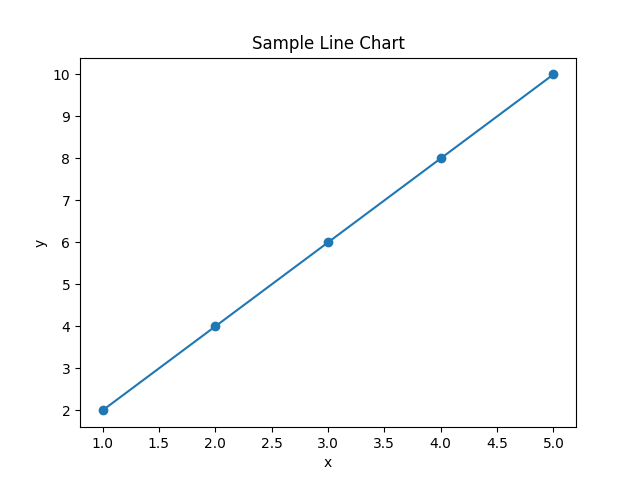

In [4]:
import base64
import io
from PIL import Image

c = output.charts[0]

bytes = base64.b64decode(c)
img = Image.open(io.BytesIO(bytes))
img

# Test async call OpenAI API

In [1]:
from settings.llm import *
import asyncio
from tool import *
from cache import cache

In [2]:
specbooks = cache["specbooks"]
specbook_numbers = list(cache["specbooks"].keys())
query = "Extract all the information about the Chassis group and anything related to it"


In [ ]:
import asyncio, time, statistics, logging
LOG = logging.getLogger("prof")

TASK_TIMES: dict[str, dict[str, float]] = {}

class Gauge:
    """Semaphore wrapper that records queue-time and run-time."""
    current_running = 0
    peak_running    = 0
    wait_times, runtimes = [], []

    def __init__(self, sem: asyncio.Semaphore):
        self.sem = sem
        self._wait = self._run = None

    async def __aenter__(self):
        q0 = time.perf_counter()
        await self.sem.acquire()                  # blocks while waiting for a slot
        self._start = time.perf_counter()
        self._wait   = self._start - q0           # queue-time
        Gauge.wait_times.append(self._wait)

        Gauge.current_running += 1
        Gauge.peak_running = max(Gauge.peak_running, Gauge.current_running)
        return self                                # so caller can read self._wait

    async def __aexit__(self, exc_type, exc, tb):
        self.sem.release()
        Gauge.current_running -= 1
        self._run = time.perf_counter() - self._start
        Gauge.runtimes.append(self._run)

# ────────────────────────── 2.  Worker coroutine ──────────────────────────
import random

import time, logging, asyncio, statistics
from openai import AsyncOpenAI           # v1.* SDK
LOG = logging.getLogger("prof")

async def _process_one(spec_no: str) -> tuple[str, SpecbookRelevanceContent]:
    content = specbooks[spec_no].content
    t0 = time.perf_counter()

    completion = await acompletion_with_backoff(
        model="gpt-4o-mini",
        input=[
            {"role": "system",
             "content": SPECBOOK_RELEVANCE_PROMPT.format(query=query)},
            {"role": "user", "content": content}
        ],
        text_format=SpecbookRelevanceContent,
    )

    t1 = time.perf_counter()
    wall_s   = t1 - t0                      # tổng thời gian thực tế
    server_s = (completion.response_ms or 0)/1000
    queue_s  = wall_s - server_s            # phần “chờ” phía OpenAI

    TASK_TIMES[spec_no] = {
        "wall":   wall_s,
        "server": server_s,
        "queue":  queue_s,
        "request_id": completion.request_id   # header x-request-id
    }
    return spec_no, completion.output_parsed


# ────────────────────────── 3.  Launch & inspect ──────────────────────────
results = await asyncio.gather(*(_process_one(n) for n in specbook_numbers[:20]))

# Build a dict for quick lookup of parsed results by spec_no
parsed_dict = {spec_no: parsed for spec_no, parsed in results}

# Print TASK_TIMES sorted by run time descending and also print parsed
for spec_no, times in sorted(TASK_TIMES.items(), key=lambda x: x[1]['run'], reverse=True):
    print(f"{spec_no:>6} | wait={times['wait']:.3f}s | run={times['run']:.3f}s (sorted)")
    parsed = parsed_dict.get(spec_no)
    print(parsed.relevance_content[:30])
    print("—" * 40)

# Global summary
print(
    "peak=%d  mean_wait=%.3f s  mean_run=%.3f s"
    % (
        Gauge.peak_running,
        statistics.mean(Gauge.wait_times),
        statistics.mean(Gauge.runtimes),
    )
)


VFDSXVDCL0019 | wait=0.000s | run=19.335s (sorted)

————————————————————————————————————————
VFDSXVEEP9120 | wait=0.000s | run=8.381s (sorted)
### Section 2.3: Feature Defin
————————————————————————————————————————
VFDSXVCHS0009 | wait=0.000s | run=7.187s (sorted)
### Relevant Information Extra
————————————————————————————————————————
VFDSXVBEX0030 | wait=0.000s | run=6.122s (sorted)
### Components Related to the 
————————————————————————————————————————
VFDSXVDCL0016 | wait=0.000s | run=5.780s (sorted)
### Key Relevant Content

**5.
————————————————————————————————————————
VFDSXVCHS0534 | wait=0.000s | run=5.488s (sorted)
### Relevant Content Extracted
————————————————————————————————————————
VFDSXVEEP0011 | wait=0.000s | run=5.299s (sorted)
### 3. System Description
####
————————————————————————————————————————
VFDSXNEEP0006 | wait=0.000s | run=4.628s (sorted)

————————————————————————————————————————
VFDSXNBAT0004 | wait=0.000s | run=4.065s (sorted)

————————————————————————————————

In [30]:
no, parsed = await _process_one("VFDSXVCHS0534")
print(parsed.is_relevant)
print(parsed.relevance_content)


True
**Front Upper and Lower Ball Joint Assemblies** (located on Page 7): 

1. **Front Upper Ball Joint Assembly LH**  
   - **Part No.**: CHS30002103  
   - **Material Requirement**: Specified as Ref 3.4  
   - **Applicability**: VN for VF35 ECO and VFe35 Plus models, ALL MARKETS for VFe35 ECO, VFe35 PLUS, and VFe35 PREMIUM models.
   - **Weight**: 1.1 Kg (Housing: 0.755 Kg; Ball Stud: 0.323 Kg)  
   - **Design Requirements**: Must be made of material specified and meet the functional/performance requirements.  

2. **Front Upper Ball Joint Assembly RH**  
   - **Part No.**: CHS30002110  
   - Same requirements as the LH version.  

3. **Front Lower Ball Joint Assembly LH**  
   - **Part No.**: CHS30002102  
   - Same requirements as for the Upper Ball Joint assemblies.  

4. **Front Lower Ball Joint Assembly RH**  
   - **Part No.**: CHS30002108  
   - Same requirements as for the other assemblies.  

These parts are mentioned under **Section 3.2** Technical Requirements in the speci

### Relevant Information Extracted:

1. **Functional Overview of LKA/LDW/ELK** (Section 2.3):  
   - **LDW**: Detects lane markings and provides warnings to prevent unintentional departures.  
   - **LKA**: Keeps the vehicle centered in its lane with steering intervention.  
   - **ELK**: Prevents collisions with steering interventions for oncoming or overtaking vehicles when the system detects deviation from the lane.  
   - **Intervention Zones** are defined for where these systems activate based on vehicle dynamics and environmental inputs.

2. **Operational Conditions and States** (Section 2.5):  
   - Describes **state transitions** (e.g. from "OFF" to "Standby" to "Active") and the conditions that trigger each state, including vehicle speed and lateral/longitudinal acceleration thresholds.
   - Specific **input signals** such as steering torque, lateral and longitudinal accelerations are critical for controlling chassis interventions.  
   - Conditions and parameters impact how f

In [42]:
for spec_no, parsed in results:
    
    
    if parsed is None:
        continue                                 # skip failed ones
    times = TASK_TIMES[spec_no]
    
    if spec_no == "VFDSXVEEP9124":
        print(f"{spec_no:>6} | wait={times['wait']:.3f}s | run={times['run']:.3f}s")
        print(parsed)
        print("—" * 40)

VFDSXVEEP9124 | wait=0.000s | run=8.129s
reasoning='The query requests information specifically about the Chassis group and anything related to it. In the provided specbook, relevant sections surrounding Chassis can be found, particularly under Section 7.6 (Interfaces) and 7.6.1.3 (Signals input from Chassis and Powertrain) which cover signal inputs specifically related to the chassis. Specifically, there is a section that discusses signal inputs from both the Chassis and Powertrain, noting various signals, their descriptions, and their value ranges. The relevant information regarding chassis signals is explicitly laid out in detail, along with functional contexts where these signals are applicable. Therefore, the specbook contains explicit and comprehensive information fulfilling the query about the Chassis group.' relevance_content='### 7.6.1.3 / Signals input from Chassis and Powertrain.\n\nRequirement ID: FS-226361.  \nType: Information.  \nStatus: New.  \n\n**Signal Name:** 0xD9.V

In [34]:
print(num)

reasoning="The query requests all information related to the chassis group, which is notably addressed in section 7.6.1.3, titled 'Signals input from Chassis and Powertrain'. This section includes multiple signals and their descriptions that directly pertain to chassis functionalities, providing critical information for understanding how the chassis interacts with other systems. Specifically, it covers signal names, their descriptions, and the valid value ranges for various chassis-related functionalities. The section encompasses comprehensive details across pages 22 through 27, thus fulfilling the query's requirement for thorough information regarding the chassis. There are also references to chassis functions in various parts of the document, primarily under the AEB and FCW functions that indirectly connect to chassis signals and operations." relevance_content='### 7.6.1.3 / Signals input from Chassis and Powertrain\n**Requirement ID:** FS-226361  \n**Type:** Information  \n**Status:

# Convert specbook md to xml format

In [3]:
import os
import re

# Template for the XML output
FILE_TMPL = """
<filename>{name}</filename>
<pages>
{pages}
</pages>
"""

PAGE_TMPL = """
<page number="{num}">
{content}
</page>"""

def clean_toc_dots(text: str) -> str:
    """
    Remove lines or segments with long sequences of dots (e.g. '.............') 
    which are typically used in table of contents.
    """
    # Remove lines that are mostly dots or have a long sequence of dots
    # Remove any sequence of 6 or more consecutive dots
    cleaned_lines = []
    for line in text.splitlines():
        # Remove lines that are only dots or mostly dots
        if re.fullmatch(r'\s*\.{4,}\s*', line):
            continue
        # Remove long dot sequences within a line
        line = re.sub(r'\.{4,}', '', line)
        cleaned_lines.append(line)
    return "\n".join(cleaned_lines)

def parse_pages(text):
    """
    Parse the text into pages based on 'Page [number]' markers.
    Also remove long dot sequences from each page's content.
    """
    pattern = r'Page\s+(\d+)'
    matches = list(re.finditer(pattern, text))
    pages = []
    for i, match in enumerate(matches):
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        num = match.group(1)
        # Extract content for this page
        content = text[start:end].strip()
        # Clean out table of contents dot lines/sequences
        content = clean_toc_dots(content)
        pages.append((num, content))
    return pages

def process_file(path: Path, out_dir: Path):
    """
    Process a single file: parse pages, clean dot lines, and write XML output.
    """
    with open(path, 'r', encoding='utf-8') as f:
        txt = f.read()
    pages = parse_pages(txt)
    pages_xml = "\n".join([PAGE_TMPL.format(num=num, content=content) for num, content in pages])
    content = FILE_TMPL.format(name=path.stem, pages=pages_xml)
    
    # Create the output directory if it does not exist, then save the file
    dst = out_dir / f"{path.stem}.txt"
    with open(dst, "w", encoding="utf-8") as f:
        f.write(content)
    return content

def process_folder(folder: Path, out_dir: Path):
    """
    Process all .txt files in a folder, converting them to cleaned XML format.
    """
    xml_files = []
    for fpath in folder.iterdir():
        if fpath.suffix == ".txt":
            xml = process_file(fpath, out_dir)
            xml_files.append(xml)
    return xml_files

# Example usage
folder_path = Path('data/specbook/specbook_md_rewrite')
out_dir = Path('data/specbook/specbook_md_xml')
out_dir.mkdir(parents=True, exist_ok=True)

files = folder_path.glob('*.txt')
print(len(list(files)))

xmls = process_folder(folder_path, out_dir)


653


In [5]:
i = 1

while i > 10:
    i += 1
    print(i)

# Test Translate

In [ ]:
import asyncio

from agents import Agent, ItemHelpers, Runner, trace
from settings.llm import *

"""
This example shows the parallelization pattern. We run the agent three times in parallel, and pick
the best result.
"""

english_agent = Agent(
    name="english_agent",
    instructions="You translate the user's message to english",
)

english_picker = Agent(
    name="english_picker",
    instructions="You pick the best english translation from the given options.",
)


async def main():
    
    msg = input("Hi! Enter a message, and we'll translate it to english.\n\n")

    res_1, res_2, res_3 = await asyncio.gather(
        Runner.run(
            english_agent,
            msg,
        ),
        Runner.run(
            english_agent,
            msg,
        ),
        Runner.run(
            english_agent,
            msg,
        ),
    )

    outputs = [
        ItemHelpers.text_message_outputs(res_1.new_items),
        ItemHelpers.text_message_outputs(res_2.new_items),
        ItemHelpers.text_message_outputs(res_3.new_items),
    ]

    translations = "\n\n".join(outputs)
    # print(f"\n\nTranslations:\n\n{translations}")

    best_translation = await Runner.run(
        english_picker,
        f"Input: {msg}\n\nTranslations:\n{translations}",
    )

    print("\n\n-----")

    print(f"Best translation: {best_translation.final_output}")


if __name__ == "__main__":
    asyncio.run(main())

# Extract part information from MBOM, Assy, Subcontract

In [2]:
import pandas as pd
from io import StringIO
from spec.utils.s3 import S3Manager
from spec.utils.llm import completion_with_backoff, LLM
from spec.utils.utils import *

s3 = S3Manager()


In [8]:
import pandas as pd
from io import StringIO
from pathlib import Path

def preprocess(path):
    raw = s3._get(path).decode("utf-8")
    lines = [line for line in raw.splitlines() if not line.startswith("#")]
    if lines and lines[0].startswith("bl"):
        lines[0] = lines[0].replace(",", "|")
    return pd.read_csv(StringIO("\n".join(lines)), delimiter="|", dtype=str)

# Load files

models = ["VF3", "VF5", "VF6", "VF7", "VF8", "VF9", "VFe34"]
folder = ["Assembly", "MBOM", "Subcontract", "EBOM"]
date = "20250603"

dfs = []


for m in models:
    for f in folder:    
        file_paths = s3.list_files(f"{m}/{f}/{date}")
        for file_path in file_paths:
            print(file_path)
            temp_df = preprocess(file_path)
            temp_df['model'] = m
            # temp_df = temp_df[:50]
            # temp_df.to_csv(f"{m}_{f}_{date}.csv", index=False)
            dfs.append(temp_df)
            break
    break

df = pd.concat(dfs, ignore_index=True)


VF3/Assembly/20250603/20250603_731654.txt
VF3/MBOM/20250603/20250603_732562.txt
VF3/Subcontract/20250603/20250603_735130.txt
VF3/EBOM/20250603/20250603_ASU69000001AA.txt


In [ ]:
# Keep relevant columns
keep = [
    'bl_item_item_id',
    'bl_item_object_name',
    'bl_item_vf4_itm_supplier_name',
    'VL5_module_group',
    'VL5_main_module',
    'VL5_module_name',
    'VL5_torque_inf',
    'model'
]
df = df[keep]

# Clean string columns
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip().str.upper()

df.drop_duplicates(inplace=True)

# Rename and filter
df = df.rename(columns={
    'bl_item_item_id': 'part_id',
    'bl_item_object_name': 'part_name',
    'bl_item_vf4_itm_supplier_name': 'supplier_name',
    'VL5_module_group': 'module_group',
    'VL5_main_module': 'main_module',
    'VL5_module_name': 'module_name',
    'VL5_torque_inf': 'torque_inf'
})
df = df[df['part_id'].str.len() > 10]

# Save if needed
df.to_parquet('data/PLM/mbom_assy_sub_parts_all_models.parquet')

df

In [ ]:
vs = VectorStore("PDF_search/vector_store/vinfast_part.pkl", s3, 1536, llm)

In [ ]:
chunks = vs.list_chunks()
part_ids = [c['chunk']['metadata']['Part ID'] for c in chunks]
print(len(chunks))
print(len(part_ids))

In [ ]:
DESCRIPTION_PARTNAME_PROMPT = """
Become a professional expert in the auto manufacturing industry and follow the instructions to answer the question below.
You will be given the abbreviations of parts or materials used in automotive manufacturing. Your goal is to follow the instructions below to elaborate on their structure, meaning, function, and intended use.

GENERAL GUIDELINES: Start with a high-level summary to capture the keywords contained in the name of the part or material. After the summary, go into detail to explore all the information obtained from the keywords. This should include an in-depth discussion of the meaning, function, and level of use, using professional technical terms for clarity. Always focus on the context that these are parts/materials used in automotive manufacturing.

DETAILED GUIDELINES FOR ANSWER DATA FORMAT: Your audience needs a comprehensive description to convey the content accurately. Present a detailed overview that captures the essence of the parts/materials based on their abbreviations. Avoid confusion by not mentioning other related parts/materials, so the audience can focus clearly on that part/material. For abbreviations in the Part Name, always use the descriptive name followed by the abbreviation, e.g., Body Control Module (BCM).

DO NOT start your description with something like "Based on the name you provided...". Instead, use "Part Name/Material: [Name]". For example: "Material: M. M is made up of...., has the shape structure...". DO NOT include line break and line break characters in the answer.

Presented in a continuous paragraph consisting of 5 main parts as follows:

Title: Has the structure of:
"Part Name/Material: Name of the supplied part/material."
Keyword and Abbreviation Explanation: Explain in detail the keywords and abbreviations in the Part Name (2 sentences).
Composition and Structure: Description of the composition of the sub-parts, common geometric structure of the part/material (2 sentences).
Meaning and Use: Based on the keywords and abbreviations, describe the meaning and use of the part/material (2 sentences).
Scope of Use: Focus on the installation and use location in the car, or the location used in the manufacturing process (1 sentence).
"""

from pydantic_types.type import Chunk
from settings.llm import client

def get_part_description(part_name):
	try:
		completion = completion_with_backoff(
			model='gpt-4o-mini',
			messages = [
				{
					'role': 'system',
					'content': DESCRIPTION_PARTNAME_PROMPT
				},
				{
					'role': 'user', 'content': "Here is the name of the part in the automotive industry, Is the name of the component used in automobile manufacturing: " + part_name}
			]
		)

		return completion.choices[0].message.content

	except Exception as e:
		print(f"Error: {e}")
		return None
	
	

In [ ]:
df = pd.read_parquet('data/PLM/mbom_assy_sub_parts_all_models.parquet')

df = df[~df['part_id'].isin(part_ids)]
df

df_unique = df.drop_duplicates(subset=['part_id', 'part_name'])

# Bước 2: Duyệt từng dòng và tạo list of dict
metadatas = []
for _, row in df_unique.iterrows():
    metadatas.append({
        'Part ID': row['part_id'],
        'Part Name': row['part_name']
    })

# In kết quả
print(len(metadatas))

In [ ]:
for m in metadatas:
    print(m)
    m['Part Name'] = m['Part Name'].replace("ASSY", "ASSEMBLY")
    m['Part Name'] = m['Part Name'].replace("ASSEMBLY", "ASM")

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

new_chunks = []

def process_metadata(m):
    description = get_part_description(m['Part Name'])
    if description is not None:
        return Chunk(metadata=m, content=description)
    else:
        return None  # Nếu lỗi nghiêm trọng, bỏ qua chunk này.

with ThreadPoolExecutor(max_workers=50) as executor:
    futures = {executor.submit(process_metadata, m): m for m in metadatas}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Generating description"):
        try:
            result = future.result()
            if result is not None:
                new_chunks.append(result)
        except Exception as e:
            part_name = futures[future]['Part Name']
            print(f"Unhandled exception for '{part_name}': {e}")


In [ ]:
vs.add_chunks(new_chunks)

In [ ]:
chunks = vs.list_chunks()
part_ids = [c['chunk']['metadata']['Part ID'] for c in chunks]
print(len(chunks))
print(len(part_ids))

In [ ]:
vs.save_index()


In [ ]:
# Loại bỏ trùng lặp (nếu có) để đảm bảo mỗi part_id ánh xạ duy nhất
df_deduped = df[['part_id', 'specbook_number', 'specbook_filename', 'specbook_file_id']].drop_duplicates(subset='part_id')

# Tạo từng mapping riêng
specbook_number_map = dict(zip(df_deduped['part_id'], df_deduped['specbook_number']))
specbook_filename_map = dict(zip(df_deduped['part_id'], df_deduped['specbook_filename']))
specbook_file_id_map = dict(zip(df_deduped['part_id'], df_deduped['specbook_file_id']))